# Métricas de Desempeño en Machine Learning
## Guía Completa con Matriz de Confusión y Métricas Derivadas

**Autor:** AGF and AI Assistant  
**Fecha:** Octubre, 2025

En este notebook exploraremos las principales métricas de evaluación para modelos de Machine Learning, con especial énfasis en:

## 📋 **Contenido del Notebook**

### **Clasificación:**
1. **Matriz de Confusión** - La base de todas las métricas
2. **Métricas Básicas** - Accuracy, Precision, Recall, F1-Score
3. **Métricas Avanzadas** - Specificity, NPV, FPR, FNR
4. **Curvas ROC y AUC** - Análisis de rendimiento
5. **Precision-Recall Curves** - Para datasets desbalanceados
6. **Métricas Multiclase** - Macro, Micro, Weighted averages

### **Regresión:**
7. **MAE** (Mean Absolute Error)
8. **RMSE** (Root Mean Square Error)
9. **R²** (Coeficiente de Determinación)
10. **MAPE** (Mean Absolute Percentage Error)

### **Casos Especiales:**
11. **Datasets Desbalanceados**
12. **Selección de Métricas por Caso de Uso**
13. **Interpretación Práctica**

## 1. Configuración Inicial e Importación de Librerías

Primero importamos todas las librerías necesarias para nuestros ejemplos.

In [1]:
# Importaciones básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn para modelos y métricas
from sklearn.datasets import make_classification, make_regression, load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC

# Métricas de clasificación
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef
)

# Métricas de regresión
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error, explained_variance_score
)

# Configuración para gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Bibliotecas importadas correctamente")
print("📊 Configuración de gráficos establecida")
print("🎯 Semilla de aleatoriedad: 42")

✅ Bibliotecas importadas correctamente
📊 Configuración de gráficos establecida
🎯 Semilla de aleatoriedad: 42


## 2. Creación de Datasets de Ejemplo

Vamos a crear datasets tanto para clasificación como para regresión para demostrar las diferentes métricas.

In [2]:
def create_datasets():
    """Crea datasets de ejemplo para clasificación y regresión"""
    
    print("🔄 Creando datasets de ejemplo...")
    
    # Dataset de clasificación binaria
    X_class_bin, y_class_bin = make_classification(
        n_samples=1000, n_features=20, n_informative=10, 
        n_redundant=5, n_classes=2, n_clusters_per_class=1,
        class_sep=0.8, random_state=RANDOM_STATE
    )
    
    # Dataset de clasificación multiclase
    X_class_multi, y_class_multi = make_classification(
        n_samples=1000, n_features=20, n_informative=15,
        n_redundant=5, n_classes=3, n_clusters_per_class=1,
        class_sep=1.0, random_state=RANDOM_STATE
    )
    
    # Dataset desbalanceado
    X_imb, y_imb = make_classification(
        n_samples=1000, n_features=20, n_informative=10,
        n_redundant=5, n_classes=2, weights=[0.9, 0.1],
        random_state=RANDOM_STATE
    )
    
    # Dataset de regresión
    X_reg, y_reg = make_regression(
        n_samples=1000, n_features=10, noise=0.1,
        random_state=RANDOM_STATE
    )
    
    # Dataset real: Breast Cancer (clasificación)
    breast_cancer = load_breast_cancer()
    X_bc, y_bc = breast_cancer.data, breast_cancer.target
    
    # Dataset real: Boston Housing (regresión) - usando diabetes como alternativa
    diabetes = load_diabetes()
    X_diabetes, y_diabetes = diabetes.data, diabetes.target
    
    print("✅ Datasets creados exitosamente:")
    print(f"  📊 Clasificación binaria: {X_class_bin.shape}")
    print(f"  📊 Clasificación multiclase: {X_class_multi.shape}")
    print(f"  ⚖️ Dataset desbalanceado: {X_imb.shape} (clases: {np.bincount(y_imb)})")
    print(f"  📈 Regresión sintética: {X_reg.shape}")
    print(f"  🔬 Breast Cancer: {X_bc.shape}")
    print(f"  🏥 Diabetes: {X_diabetes.shape}")
    
    return {
        'classification_binary': (X_class_bin, y_class_bin),
        'classification_multi': (X_class_multi, y_class_multi), 
        'imbalanced': (X_imb, y_imb),
        'regression': (X_reg, y_reg),
        'breast_cancer': (X_bc, y_bc),
        'diabetes': (X_diabetes, y_diabetes)
    }

# Crear todos los datasets
datasets = create_datasets()

🔄 Creando datasets de ejemplo...
✅ Datasets creados exitosamente:
  📊 Clasificación binaria: (1000, 20)
  📊 Clasificación multiclase: (1000, 20)
  ⚖️ Dataset desbalanceado: (1000, 20) (clases: [892 108])
  📈 Regresión sintética: (1000, 10)
  🔬 Breast Cancer: (569, 30)
  🏥 Diabetes: (442, 10)


## 3. Matriz de Confusión - La Base de Todo

La **matriz de confusión** es la base fundamental para entender el rendimiento de un modelo de clasificación. Nos muestra una tabla cruzada entre las predicciones del modelo y los valores reales.

### Para clasificación binaria:
- **TP (True Positives)**: Predicciones positivas correctas
- **TN (True Negatives)**: Predicciones negativas correctas  
- **FP (False Positives)**: Falsos positivos (Error Tipo I)
- **FN (False Negatives)**: Falsos negativos (Error Tipo II)

In [3]:
def plot_confusion_matrix(cm, class_names=None, title="Matriz de Confusión", normalize=False):
    """
    Función para visualizar matrices de confusión de forma elegante
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', 
               xticklabels=class_names, yticklabels=class_names,
               cbar_kws={'label': 'Proporción' if normalize else 'Frecuencia'})
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Etiqueta Real', fontsize=12)
    plt.xlabel('Predicción del Modelo', fontsize=12)
    plt.tight_layout()

def analyze_binary_confusion_matrix(cm):
    """
    Analiza una matriz de confusión binaria y extrae todas las métricas
    """
    tn, fp, fn, tp = cm.ravel()
    
    print("📊 ANÁLISIS DE LA MATRIZ DE CONFUSIÓN")
    print("="*50)
    print(f"True Negatives (TN):  {tn:4d} | Predicciones negativas correctas")
    print(f"False Positives (FP): {fp:4d} | Falsos positivos (Error Tipo I)")
    print(f"False Negatives (FN): {fn:4d} | Falsos negativos (Error Tipo II)")  
    print(f"True Positives (TP):  {tp:4d} | Predicciones positivas correctas")
    print("-"*50)
    print(f"Total de muestras:    {tn + fp + fn + tp:4d}")
    
    return tn, fp, fn, tp

# Entrenar un modelo simple para ejemplo
X, y = datasets['classification_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

# Modelo de ejemplo
model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("🎯 Modelo entrenado y predicciones realizadas")
print(f"📊 Tamaño del conjunto de prueba: {len(y_test)} muestras")

🎯 Modelo entrenado y predicciones realizadas
📊 Tamaño del conjunto de prueba: 300 muestras


📊 ANÁLISIS DE LA MATRIZ DE CONFUSIÓN
True Negatives (TN):   144 | Predicciones negativas correctas
False Positives (FP):    8 | Falsos positivos (Error Tipo I)
False Negatives (FN):    8 | Falsos negativos (Error Tipo II)
True Positives (TP):   140 | Predicciones positivas correctas
--------------------------------------------------
Total de muestras:     300


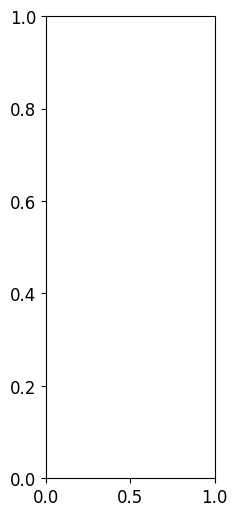

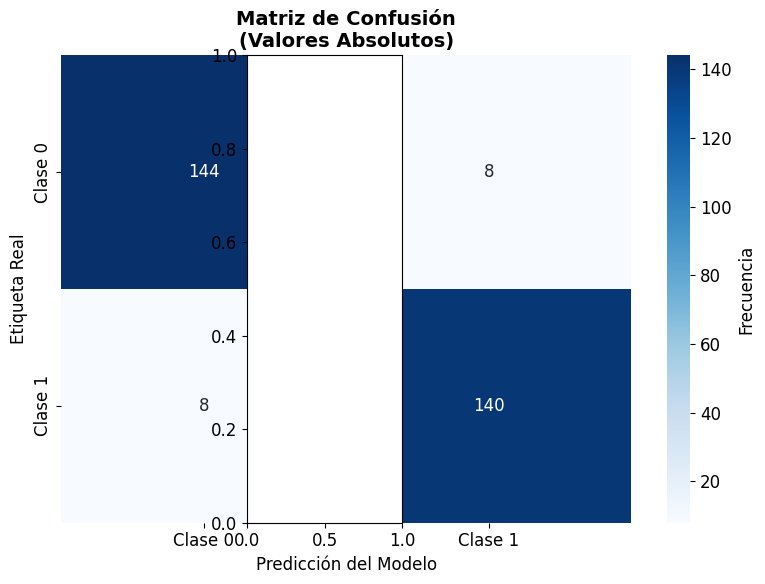

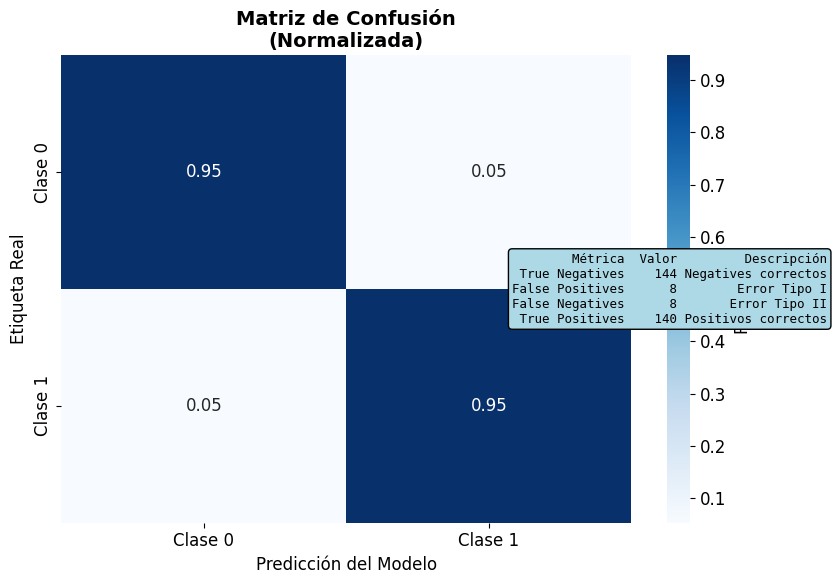

In [27]:
# Visualizar la matriz de confusión
#plt.figure(figsize=(15, 8))

# Matriz de confusión sin normalizar
plt.subplot(1, 4, 1)
plot_confusion_matrix(cm, class_names=['Clase 0', 'Clase 1'], 
                     title="Matriz de Confusión\n(Valores Absolutos)")

# Matriz de confusión normalizada
plt.subplot(1, 4, 2) 
plot_confusion_matrix(cm, class_names=['Clase 0', 'Clase 1'], 
                     title="Matriz de Confusión\n(Normalizada)", normalize=True)

# Análisis detallado
plt.subplot(1, 4, 3)
plt.axis('off')
tn, fp, fn, tp = analyze_binary_confusion_matrix(cm)

# Crear tabla de resumen
data = {
    'Métrica': ['True Negatives', 'False Positives', 'False Negatives', 'True Positives'],
    'Valor': [tn, fp, fn, tp],
    'Descripción': ['Negatives correctos', 'Error Tipo I', 'Error Tipo II', 'Positivos correctos']
}
df_summary = pd.DataFrame(data)

# Mostrar tabla
table_text = df_summary.to_string(index=False)
plt.text(0.5, 0.5, table_text, fontsize=9, fontfamily='monospace',
         horizontalalignment='left', verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

## 4. Métricas Básicas de Clasificación

A partir de la matriz de confusión, podemos calcular las métricas fundamentales de clasificación:

### 📈 **Accuracy (Exactitud)**
- **Fórmula**: `(TP + TN) / (TP + TN + FP + FN)`
- **Interpretación**: Proporción de predicciones correctas
- **Cuándo usar**: Datasets balanceados

### 🎯 **Precision (Precisión)** 
- **Fórmula**: `TP / (TP + FP)`
- **Interpretación**: De las predicciones positivas, cuántas fueron correctas
- **Cuándo usar**: Cuando los falsos positivos son costosos

### 🔍 **Recall (Sensibilidad/Sensitivity)**
- **Fórmula**: `TP / (TP + FN)` 
- **Interpretación**: De los casos positivos reales, cuántos detectamos
- **Cuándo usar**: Cuando los falsos negativos son costosos

### ⚖️ **F1-Score**
- **Fórmula**: `2 * (Precision * Recall) / (Precision + Recall)`
- **Interpretación**: Media armónica entre precisión y recall
- **Cuándo usar**: Cuando necesitas balance entre precision y recall

In [5]:
def calculate_all_metrics(y_true, y_pred, y_pred_proba=None):
    """
    Calcula todas las métricas de clasificación de forma comprehensiva
    """
    
    # Métricas básicas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Métricas adicionales calculadas manualmente
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
    
    # Métricas avanzadas
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    # AUC si tenemos probabilidades
    auc = roc_auc_score(y_true, y_pred_proba) if y_pred_proba is not None else None
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'npv': npv,
        'fpr': fpr,
        'fnr': fnr,
        'balanced_accuracy': balanced_acc,
        'kappa': kappa,
        'mcc': mcc,
        'auc': auc,
        'confusion_matrix': cm
    }

def display_metrics_table(metrics_dict):
    """
    Muestra las métricas en una tabla bien formateada
    """
    print("📊 RESUMEN COMPLETO DE MÉTRICAS")
    print("="*60)
    
    # Métricas básicas
    print("🔹 MÉTRICAS BÁSICAS:")
    print(f"   Accuracy (Exactitud):     {metrics_dict['accuracy']:.4f}")
    print(f"   Precision (Precisión):    {metrics_dict['precision']:.4f}")
    print(f"   Recall (Sensibilidad):    {metrics_dict['recall']:.4f}")  
    print(f"   F1-Score:                 {metrics_dict['f1_score']:.4f}")
    
    print("\n🔹 MÉTRICAS ADICIONALES:")
    print(f"   Specificity (Especificidad): {metrics_dict['specificity']:.4f}")
    print(f"   NPV (Valor Pred. Negativo):  {metrics_dict['npv']:.4f}")
    print(f"   FPR (Tasa Falsos Positivos): {metrics_dict['fpr']:.4f}")
    print(f"   FNR (Tasa Falsos Negativos): {metrics_dict['fnr']:.4f}")
    
    print("\n🔹 MÉTRICAS AVANZADAS:")
    print(f"   Balanced Accuracy:        {metrics_dict['balanced_accuracy']:.4f}")
    print(f"   Cohen's Kappa:            {metrics_dict['kappa']:.4f}")
    print(f"   Matthews Corr. Coef.:     {metrics_dict['mcc']:.4f}")
    
    if metrics_dict['auc'] is not None:
        print(f"   AUC-ROC:                  {metrics_dict['auc']:.4f}")

# Calcular todas las métricas para nuestro modelo
metrics = calculate_all_metrics(y_test, y_pred, y_pred_proba)
display_metrics_table(metrics)

📊 RESUMEN COMPLETO DE MÉTRICAS
🔹 MÉTRICAS BÁSICAS:
   Accuracy (Exactitud):     0.9467
   Precision (Precisión):    0.9459
   Recall (Sensibilidad):    0.9459
   F1-Score:                 0.9459

🔹 MÉTRICAS ADICIONALES:
   Specificity (Especificidad): 0.9474
   NPV (Valor Pred. Negativo):  0.9474
   FPR (Tasa Falsos Positivos): 0.0526
   FNR (Tasa Falsos Negativos): 0.0541

🔹 MÉTRICAS AVANZADAS:
   Balanced Accuracy:        0.9467
   Cohen's Kappa:            0.8933
   Matthews Corr. Coef.:     0.8933
   AUC-ROC:                  0.9844


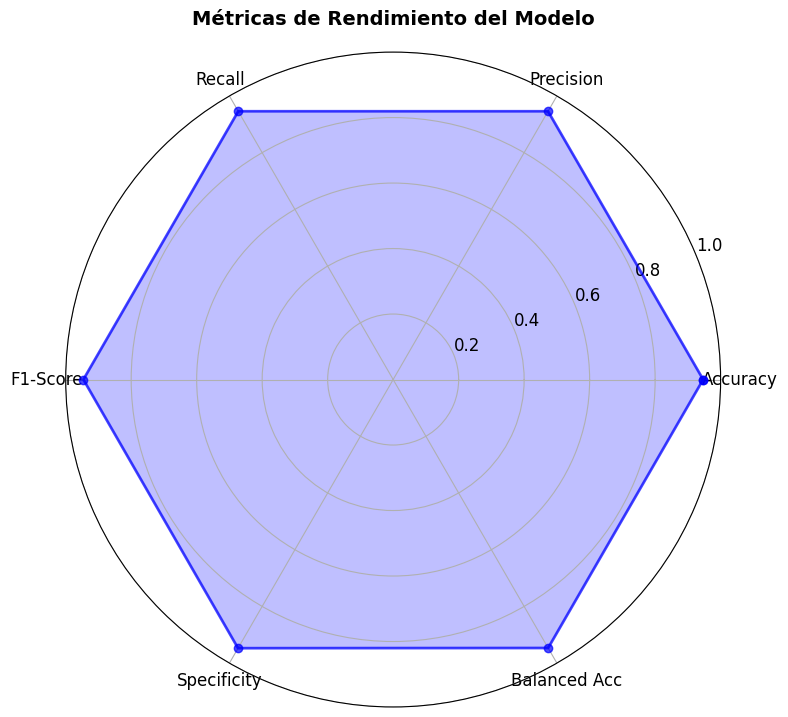

In [6]:
# Visualización de métricas con gráfico de radar
def plot_metrics_radar(metrics_dict, title="Métricas del Modelo"):
    """
    Crea un gráfico de radar para visualizar múltiples métricas
    """
    # Seleccionar métricas principales para el radar
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity', 'Balanced Acc']
    metrics_values = [
        metrics_dict['accuracy'],
        metrics_dict['precision'], 
        metrics_dict['recall'],
        metrics_dict['f1_score'],
        metrics_dict['specificity'],
        metrics_dict['balanced_accuracy']
    ]
    
    # Configurar el gráfico de radar
    angles = np.linspace(0, 2*np.pi, len(metrics_names), endpoint=False).tolist()
    metrics_values += metrics_values[:1]  # Cerrar el polígono
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    ax.plot(angles, metrics_values, 'o-', linewidth=2, color='blue', alpha=0.7)
    ax.fill(angles, metrics_values, alpha=0.25, color='blue')
    
    # Personalizar el gráfico
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics_names)
    ax.set_ylim(0, 1)
    ax.set_title(title, size=14, fontweight='bold', pad=20)
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Crear visualización de radar
plot_metrics_radar(metrics, "Métricas de Rendimiento del Modelo")

## 5. Curvas ROC y Precision-Recall

### 🔄 **Curva ROC (Receiver Operating Characteristic)**
- **Eje X**: False Positive Rate (1 - Specificity)
- **Eje Y**: True Positive Rate (Recall/Sensitivity)  
- **AUC-ROC**: Área bajo la curva ROC
- **Interpretación**: Capacidad de discriminación del modelo

### 📈 **Curva Precision-Recall**
- **Eje X**: Recall (Sensibilidad)
- **Eje Y**: Precision (Precisión)
- **AUC-PR**: Área bajo la curva Precision-Recall
- **Cuándo usar**: Especialmente útil para datasets desbalanceados

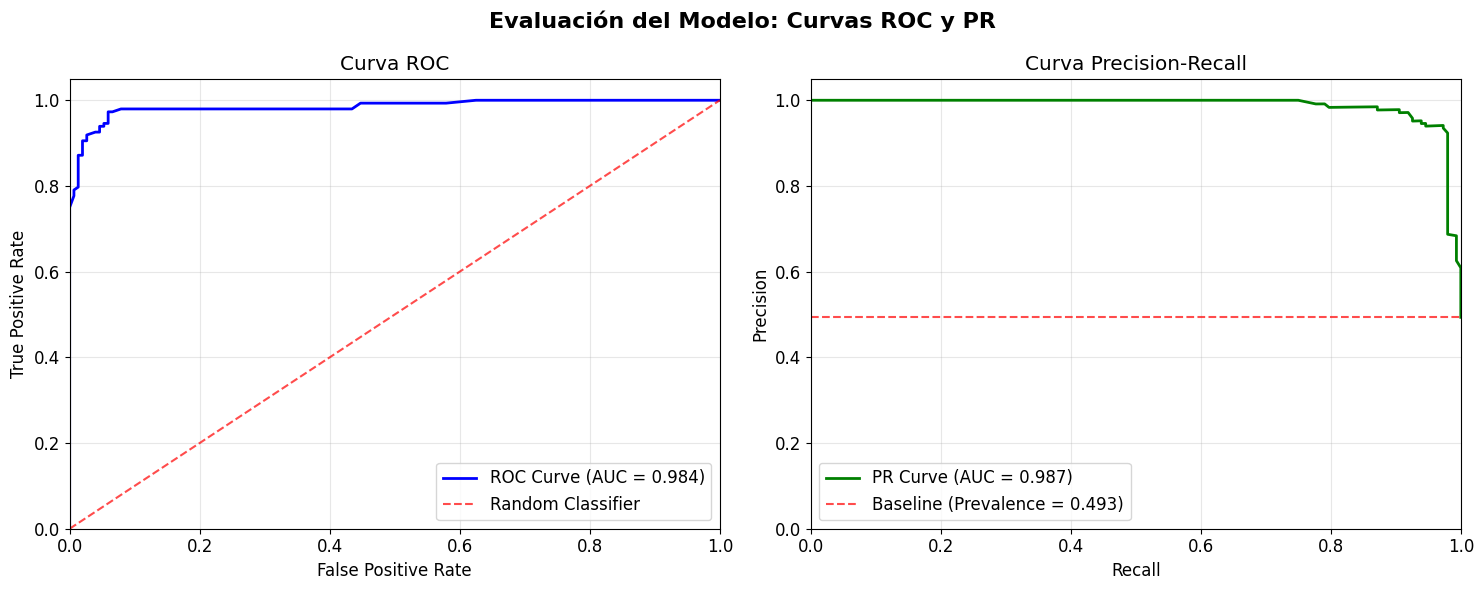

📊 AUC-ROC: 0.9844
📈 AUC-PR:  0.9869


In [7]:
def plot_roc_and_pr_curves(y_true, y_pred_proba, title="Curvas ROC y Precision-Recall"):
    """
    Plotea las curvas ROC y Precision-Recall lado a lado
    """
    # Calcular curva ROC
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    # Calcular curva Precision-Recall
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    
    # Crear subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico ROC
    ax1.plot(fpr, tpr, color='blue', linewidth=2, 
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='red', linestyle='--', alpha=0.7, 
             label='Random Classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Curva ROC')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)
    
    # Gráfico Precision-Recall
    ax2.plot(recall_curve, precision_curve, color='green', linewidth=2,
             label=f'PR Curve (AUC = {pr_auc:.3f})')
    # Línea base para datasets desbalanceados
    baseline = np.sum(y_true) / len(y_true)
    ax2.axhline(y=baseline, color='red', linestyle='--', alpha=0.7,
                label=f'Baseline (Prevalence = {baseline:.3f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision') 
    ax2.set_title('Curva Precision-Recall')
    ax2.legend(loc="lower left")
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'fpr': fpr,
        'tpr': tpr,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve
    }

# Plotear curvas para nuestro modelo
curve_metrics = plot_roc_and_pr_curves(y_test, y_pred_proba, 
                                      "Evaluación del Modelo: Curvas ROC y PR")

print(f"📊 AUC-ROC: {curve_metrics['roc_auc']:.4f}")
print(f"📈 AUC-PR:  {curve_metrics['pr_auc']:.4f}")

## 6. Métricas para Datasets Desbalanceados

Los datasets desbalanceados requieren métricas especiales ya que el accuracy puede ser engañoso.

### 🎯 **Caso de Uso: Detección de Fraude**
- **Clase Mayoritaria**: Transacciones normales (99%)
- **Clase Minoritaria**: Transacciones fraudulentas (1%)
- **Problema**: Un modelo que predice "no fraude" siempre tendría 99% de accuracy

In [8]:
# Entrenar modelos en dataset desbalanceado
X_imb, y_imb = datasets['imbalanced']
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_imb, y_imb, test_size=0.3, random_state=RANDOM_STATE, stratify=y_imb
)

print("📊 ANÁLISIS DE DATASET DESBALANCEADO")
print("="*50)
print(f"Distribución de clases en entrenamiento:")
print(f"  Clase 0: {np.sum(y_train_imb == 0):4d} muestras ({np.mean(y_train_imb == 0)*100:.1f}%)")
print(f"  Clase 1: {np.sum(y_train_imb == 1):4d} muestras ({np.mean(y_train_imb == 1)*100:.1f}%)")

# Modelo sin ajustar para datasets desbalanceados
model_default = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
model_default.fit(X_train_imb, y_train_imb)
y_pred_default = model_default.predict(X_test_imb)
y_pred_proba_default = model_default.predict_proba(X_test_imb)[:, 1]

# Modelo ajustado para datasets desbalanceados
model_balanced = RandomForestClassifier(n_estimators=100, 
                                      class_weight='balanced', 
                                      random_state=RANDOM_STATE)
model_balanced.fit(X_train_imb, y_train_imb)
y_pred_balanced = model_balanced.predict(X_test_imb)
y_pred_proba_balanced = model_balanced.predict_proba(X_test_imb)[:, 1]

print("\n🎯 Modelos entrenados:")
print("  1. Modelo Default (sin ajuste para desbalance)")
print("  2. Modelo Balanced (class_weight='balanced')")

📊 ANÁLISIS DE DATASET DESBALANCEADO
Distribución de clases en entrenamiento:
  Clase 0:  624 muestras (89.1%)
  Clase 1:   76 muestras (10.9%)

🎯 Modelos entrenados:
  1. Modelo Default (sin ajuste para desbalance)
  2. Modelo Balanced (class_weight='balanced')


In [9]:
# Comparar métricas entre modelos
def compare_imbalanced_metrics(y_true, y_pred1, y_pred_proba1, y_pred2, y_pred_proba2):
    """
    Compara métricas entre dos modelos para datasets desbalanceados
    """
    
    metrics1 = calculate_all_metrics(y_true, y_pred1, y_pred_proba1)
    metrics2 = calculate_all_metrics(y_true, y_pred2, y_pred_proba2)
    
    print("📊 COMPARACIÓN DE MODELOS EN DATASET DESBALANCEADO")
    print("="*70)
    print(f"{'Métrica':<25} {'Modelo Default':<15} {'Modelo Balanced':<15} {'Diferencia':<10}")
    print("-"*70)
    
    for metric in ['accuracy', 'precision', 'recall', 'f1_score', 'balanced_accuracy', 'auc']:
        val1 = metrics1[metric]
        val2 = metrics2[metric] 
        diff = val2 - val1 if val1 is not None and val2 is not None else 'N/A'
        
        if isinstance(diff, float):
            print(f"{metric:<25} {val1:<15.4f} {val2:<15.4f} {diff:<+10.4f}")
        else:
            print(f"{metric:<25} {val1:<15} {val2:<15} {diff:<10}")
    
    return metrics1, metrics2

# Comparar métricas
metrics_default, metrics_balanced = compare_imbalanced_metrics(
    y_test_imb, y_pred_default, y_pred_proba_default,
    y_pred_balanced, y_pred_proba_balanced
)

📊 COMPARACIÓN DE MODELOS EN DATASET DESBALANCEADO
Métrica                   Modelo Default  Modelo Balanced Diferencia
----------------------------------------------------------------------
accuracy                  0.9233          0.9167          -0.0067   
precision                 1.0000          1.0000          +0.0000   
recall                    0.2812          0.2188          -0.0625   
f1_score                  0.4390          0.3590          -0.0801   
balanced_accuracy         0.6406          0.6094          -0.0312   
auc                       0.8849          0.9307          +0.0458   


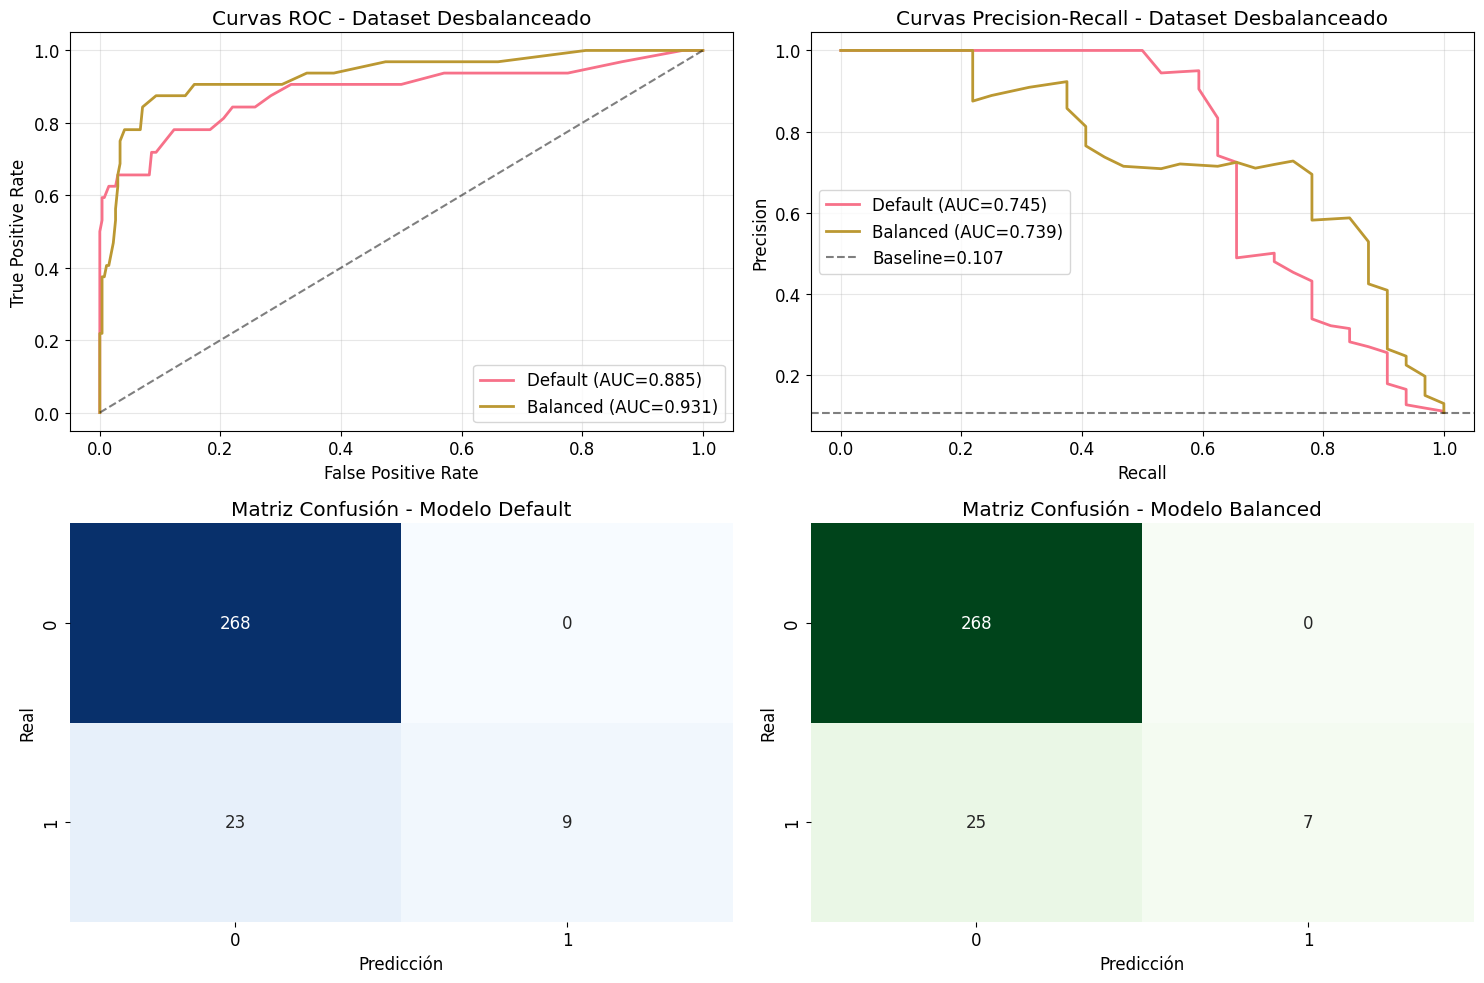

In [10]:
# Visualizar curvas ROC y PR para datasets desbalanceados
plt.figure(figsize=(15, 10))

# Curvas ROC
plt.subplot(2, 2, 1)
fpr1, tpr1, _ = roc_curve(y_test_imb, y_pred_proba_default)
fpr2, tpr2, _ = roc_curve(y_test_imb, y_pred_proba_balanced) 
auc1 = roc_auc_score(y_test_imb, y_pred_proba_default)
auc2 = roc_auc_score(y_test_imb, y_pred_proba_balanced)

plt.plot(fpr1, tpr1, label=f'Default (AUC={auc1:.3f})', linewidth=2)
plt.plot(fpr2, tpr2, label=f'Balanced (AUC={auc2:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC - Dataset Desbalanceado')
plt.legend()
plt.grid(True, alpha=0.3)

# Curvas Precision-Recall
plt.subplot(2, 2, 2)
p1, r1, _ = precision_recall_curve(y_test_imb, y_pred_proba_default)
p2, r2, _ = precision_recall_curve(y_test_imb, y_pred_proba_balanced)
pr_auc1 = average_precision_score(y_test_imb, y_pred_proba_default)
pr_auc2 = average_precision_score(y_test_imb, y_pred_proba_balanced)

plt.plot(r1, p1, label=f'Default (AUC={pr_auc1:.3f})', linewidth=2)
plt.plot(r2, p2, label=f'Balanced (AUC={pr_auc2:.3f})', linewidth=2)
baseline = np.mean(y_test_imb)
plt.axhline(y=baseline, color='k', linestyle='--', alpha=0.5, 
           label=f'Baseline={baseline:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curvas Precision-Recall - Dataset Desbalanceado')
plt.legend()
plt.grid(True, alpha=0.3)

# Matrices de confusión
plt.subplot(2, 2, 3)
cm1 = confusion_matrix(y_test_imb, y_pred_default)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz Confusión - Modelo Default')
plt.ylabel('Real')
plt.xlabel('Predicción')

plt.subplot(2, 2, 4)  
cm2 = confusion_matrix(y_test_imb, y_pred_balanced)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Matriz Confusión - Modelo Balanced')
plt.ylabel('Real')
plt.xlabel('Predicción')

plt.tight_layout()
plt.show()

## 7. Métricas de Regresión

Para problemas de regresión, tenemos un conjunto diferente de métricas basadas en la diferencia entre valores reales y predichos.

### 📏 **MAE (Mean Absolute Error)**
- **Fórmula**: `Σ|y_real - y_pred| / n`
- **Interpretación**: Error promedio en las mismas unidades que la variable objetivo
- **Robustez**: Robusto a outliers

### 📐 **RMSE (Root Mean Square Error)**
- **Fórmula**: `√(Σ(y_real - y_pred)² / n)`
- **Interpretación**: Penaliza más los errores grandes
- **Sensibilidad**: Sensible a outliers

### 📊 **R² (Coeficiente de Determinación)**
- **Fórmula**: `1 - (SS_res / SS_tot)`
- **Interpretación**: Proporción de varianza explicada por el modelo
- **Rango**: -∞ a 1 (1 = predicción perfecta)

### 📈 **MAPE (Mean Absolute Percentage Error)**
- **Fórmula**: `Σ|((y_real - y_pred) / y_real)| / n * 100`
- **Interpretación**: Error porcentual promedio
- **Uso**: Fácil interpretación en términos de porcentaje

In [11]:
# Entrenar modelo de regresión
X_reg, y_reg = datasets['regression']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=RANDOM_STATE
)

# Modelo de regresión
model_reg = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
model_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = model_reg.predict(X_test_reg)

def calculate_regression_metrics(y_true, y_pred):
    """
    Calcula todas las métricas de regresión importantes
    """
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Evitar división por cero para MAPE
    mask = y_true != 0
    if np.any(mask):
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.inf
    
    explained_var = explained_variance_score(y_true, y_pred)
    
    # Métricas adicionales
    residuals = y_true - y_pred
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)
    
    return {
        'mae': mae,
        'mse': mse, 
        'rmse': rmse,
        'r2': r2,
        'mape': mape,
        'explained_variance': explained_var,
        'mean_residual': mean_residual,
        'std_residual': std_residual,
        'residuals': residuals
    }

def display_regression_metrics(metrics_dict):
    """
    Muestra las métricas de regresión en formato tabular
    """
    print("📊 MÉTRICAS DE REGRESIÓN")
    print("="*50)
    print(f"MAE (Mean Absolute Error):      {metrics_dict['mae']:.4f}")
    print(f"MSE (Mean Squared Error):       {metrics_dict['mse']:.4f}")
    print(f"RMSE (Root Mean Squared Error): {metrics_dict['rmse']:.4f}")
    print(f"R² (Coef. Determinación):       {metrics_dict['r2']:.4f}")
    print(f"MAPE (Mean Abs. Perc. Error):   {metrics_dict['mape']:.2f}%")
    print(f"Explained Variance Score:       {metrics_dict['explained_variance']:.4f}")
    print("-"*50)
    print(f"Mean Residual:                  {metrics_dict['mean_residual']:.4f}")
    print(f"Std Residual:                   {metrics_dict['std_residual']:.4f}")

# Calcular métricas de regresión
reg_metrics = calculate_regression_metrics(y_test_reg, y_pred_reg)
display_regression_metrics(reg_metrics)

📊 MÉTRICAS DE REGRESIÓN
MAE (Mean Absolute Error):      41.0032
MSE (Mean Squared Error):       2788.0335
RMSE (Root Mean Squared Error): 52.8018
R² (Coef. Determinación):       0.8496
MAPE (Mean Abs. Perc. Error):   85.15%
Explained Variance Score:       0.8517
--------------------------------------------------
Mean Residual:                  6.2057
Std Residual:                   52.4359


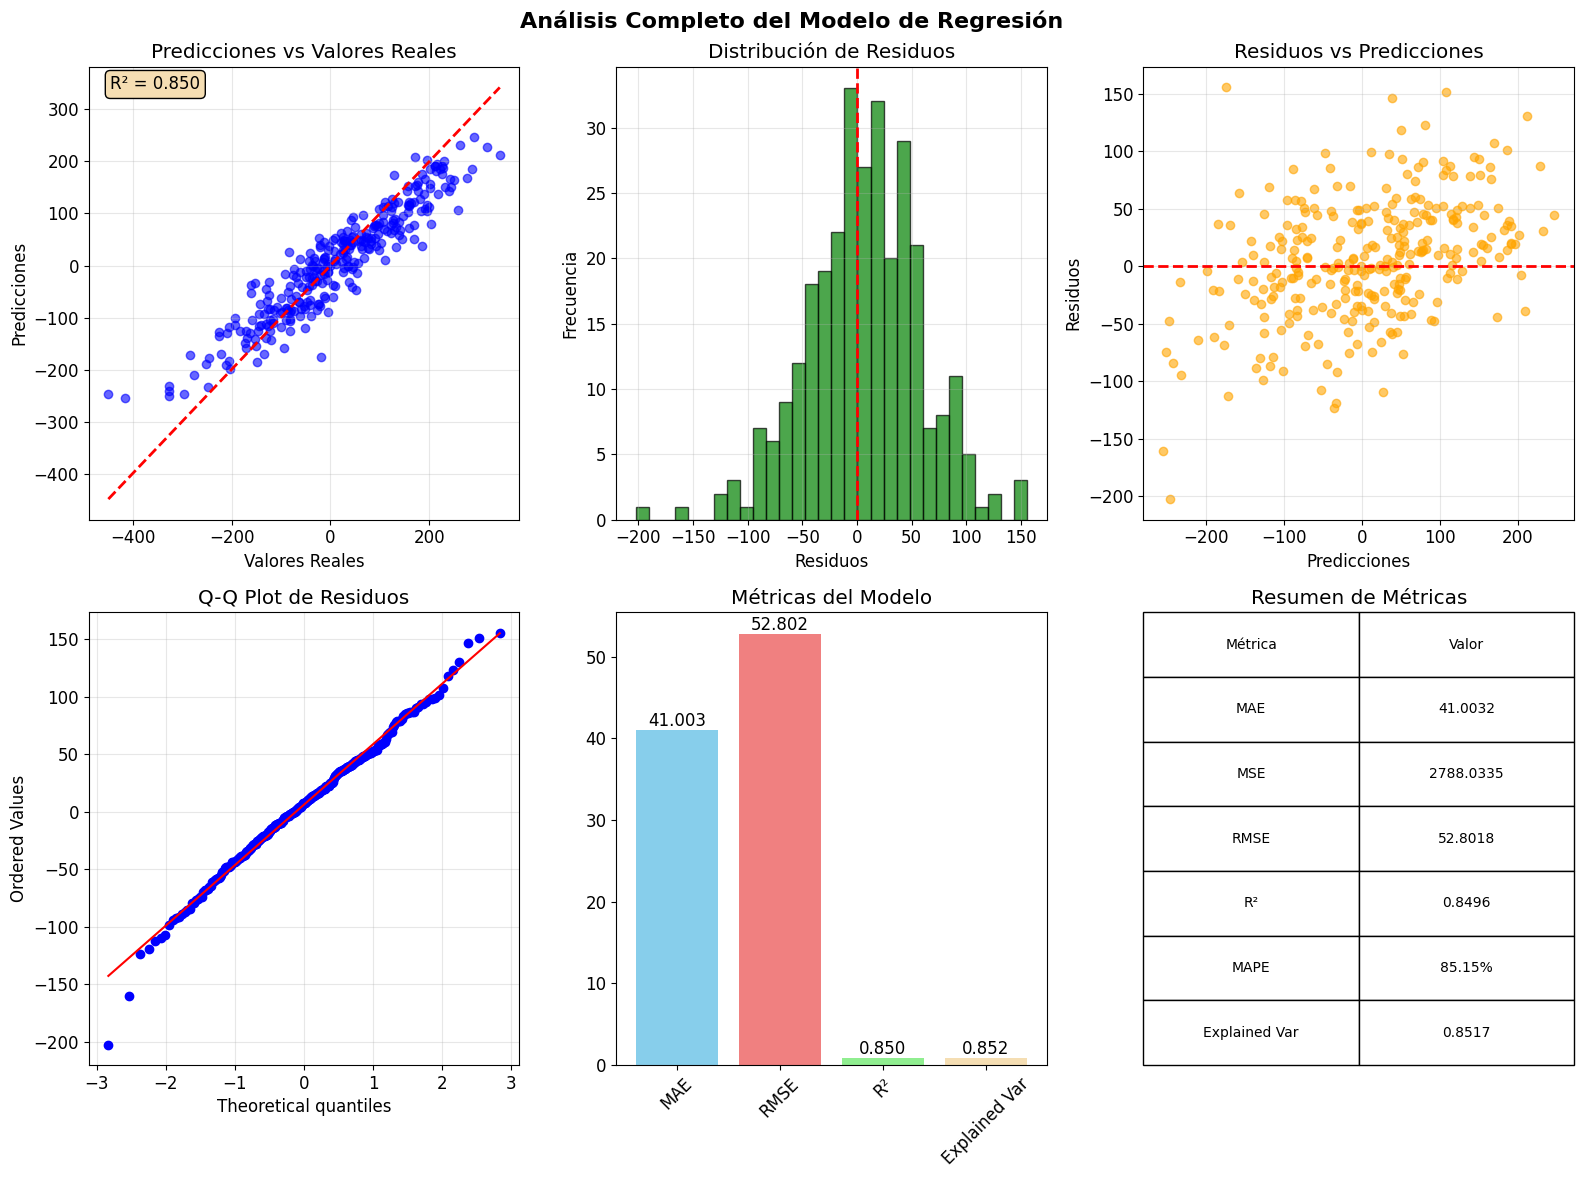

In [12]:
# Visualizar análisis de residuos y métricas de regresión
def plot_regression_analysis(y_true, y_pred, metrics_dict, title="Análisis de Regresión"):
    """
    Crea visualizaciones comprehensivas para análisis de regresión
    """
    
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Predicciones vs Valores Reales
    plt.subplot(2, 3, 1)
    plt.scatter(y_true, y_pred, alpha=0.6, color='blue')
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title('Predicciones vs Valores Reales')
    plt.grid(True, alpha=0.3)
    
    # Añadir R² en el gráfico
    plt.text(0.05, 0.95, f'R² = {metrics_dict["r2"]:.3f}', 
             transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
    
    # 2. Distribución de Residuos
    plt.subplot(2, 3, 2)
    residuals = metrics_dict['residuals']
    plt.hist(residuals, bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Residuos')
    plt.grid(True, alpha=0.3)
    
    # 3. Residuos vs Predicciones
    plt.subplot(2, 3, 3)
    plt.scatter(y_pred, residuals, alpha=0.6, color='orange')
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    plt.title('Residuos vs Predicciones')
    plt.grid(True, alpha=0.3)
    
    # 4. Q-Q Plot de Residuos
    plt.subplot(2, 3, 4)
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot de Residuos')
    plt.grid(True, alpha=0.3)
    
    # 5. Métricas en formato visual
    plt.subplot(2, 3, 5)
    metrics_names = ['MAE', 'RMSE', 'R²', 'Explained Var']
    metrics_values = [metrics_dict['mae'], metrics_dict['rmse'], 
                     metrics_dict['r2'], metrics_dict['explained_variance']]
    
    bars = plt.bar(metrics_names, metrics_values, color=['skyblue', 'lightcoral', 'lightgreen', 'wheat'])
    plt.title('Métricas del Modelo')
    plt.xticks(rotation=45)
    
    # Añadir valores en las barras
    for bar, value in zip(bars, metrics_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    # 6. Tabla de métricas
    plt.subplot(2, 3, 6)
    plt.axis('off')
    metrics_table = [
        ['Métrica', 'Valor'],
        ['MAE', f'{metrics_dict["mae"]:.4f}'],
        ['MSE', f'{metrics_dict["mse"]:.4f}'],
        ['RMSE', f'{metrics_dict["rmse"]:.4f}'],
        ['R²', f'{metrics_dict["r2"]:.4f}'],
        ['MAPE', f'{metrics_dict["mape"]:.2f}%'],
        ['Explained Var', f'{metrics_dict["explained_variance"]:.4f}']
    ]
    
    table = plt.table(cellText=metrics_table[1:], colLabels=metrics_table[0],
                     cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    plt.title('Resumen de Métricas')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Crear análisis visual completo
plot_regression_analysis(y_test_reg, y_pred_reg, reg_metrics, 
                        "Análisis Completo del Modelo de Regresión")

## 8. Clasificación Multiclase

Para problemas de clasificación multiclase, las métricas se pueden calcular de diferentes maneras:

### 🎯 **Estrategias de Promediado:**
- **Macro Average**: Promedio simple de métricas por clase
- **Micro Average**: Calcula métricas globalmente
- **Weighted Average**: Promedio ponderado por soporte de clase

### 📊 **Métricas Específicas:**
- **Accuracy**: Se mantiene igual
- **Precision/Recall/F1**: Se calculan por clase y se promedian

In [13]:
# Entrenar modelo multiclase
X_multi, y_multi = datasets['classification_multi']
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=RANDOM_STATE, stratify=y_multi
)

model_multi = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
model_multi.fit(X_train_multi, y_train_multi)
y_pred_multi = model_multi.predict(X_test_multi)
y_pred_proba_multi = model_multi.predict_proba(X_test_multi)

def analyze_multiclass_metrics(y_true, y_pred):
    """
    Análisis completo de métricas para clasificación multiclase
    """
    
    # Métricas globales
    accuracy = accuracy_score(y_true, y_pred)
    
    # Métricas por estrategia de promediado
    precision_macro = precision_score(y_true, y_pred, average='macro')
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    
    recall_macro = recall_score(y_true, y_pred, average='macro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    # Métricas por clase individual
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    print("📊 MÉTRICAS DE CLASIFICACIÓN MULTICLASE")
    print("="*60)
    print(f"Accuracy Global:                    {accuracy:.4f}")
    print("\n🎯 MÉTRICAS POR ESTRATEGIA DE PROMEDIADO:")
    print(f"{'Métrica':<15} {'Macro':<10} {'Micro':<10} {'Weighted':<10}")
    print("-"*50)
    print(f"{'Precision':<15} {precision_macro:<10.4f} {precision_micro:<10.4f} {precision_weighted:<10.4f}")
    print(f"{'Recall':<15} {recall_macro:<10.4f} {recall_micro:<10.4f} {recall_weighted:<10.4f}")
    print(f"{'F1-Score':<15} {f1_macro:<10.4f} {f1_micro:<10.4f} {f1_weighted:<10.4f}")
    
    print("\n🎯 MÉTRICAS POR CLASE:")
    print(f"{'Clase':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-"*50)
    for i in range(len(precision_per_class)):
        print(f"{i:<8} {precision_per_class[i]:<12.4f} {recall_per_class[i]:<12.4f} {f1_per_class[i]:<12.4f}")
    
    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro, 'precision_micro': precision_micro, 'precision_weighted': precision_weighted,
        'recall_macro': recall_macro, 'recall_micro': recall_micro, 'recall_weighted': recall_weighted,
        'f1_macro': f1_macro, 'f1_micro': f1_micro, 'f1_weighted': f1_weighted,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class
    }

# Analizar métricas multiclase
multiclass_metrics = analyze_multiclass_metrics(y_test_multi, y_pred_multi)

📊 MÉTRICAS DE CLASIFICACIÓN MULTICLASE
Accuracy Global:                    0.8800

🎯 MÉTRICAS POR ESTRATEGIA DE PROMEDIADO:
Métrica         Macro      Micro      Weighted  
--------------------------------------------------
Precision       0.8805     0.8800     0.8805    
Recall          0.8800     0.8800     0.8800    
F1-Score        0.8801     0.8800     0.8801    

🎯 MÉTRICAS POR CLASE:
Clase    Precision    Recall       F1-Score    
--------------------------------------------------
0        0.8586       0.8500       0.8543      
1        0.8654       0.9000       0.8824      
2        0.9175       0.8900       0.9036      


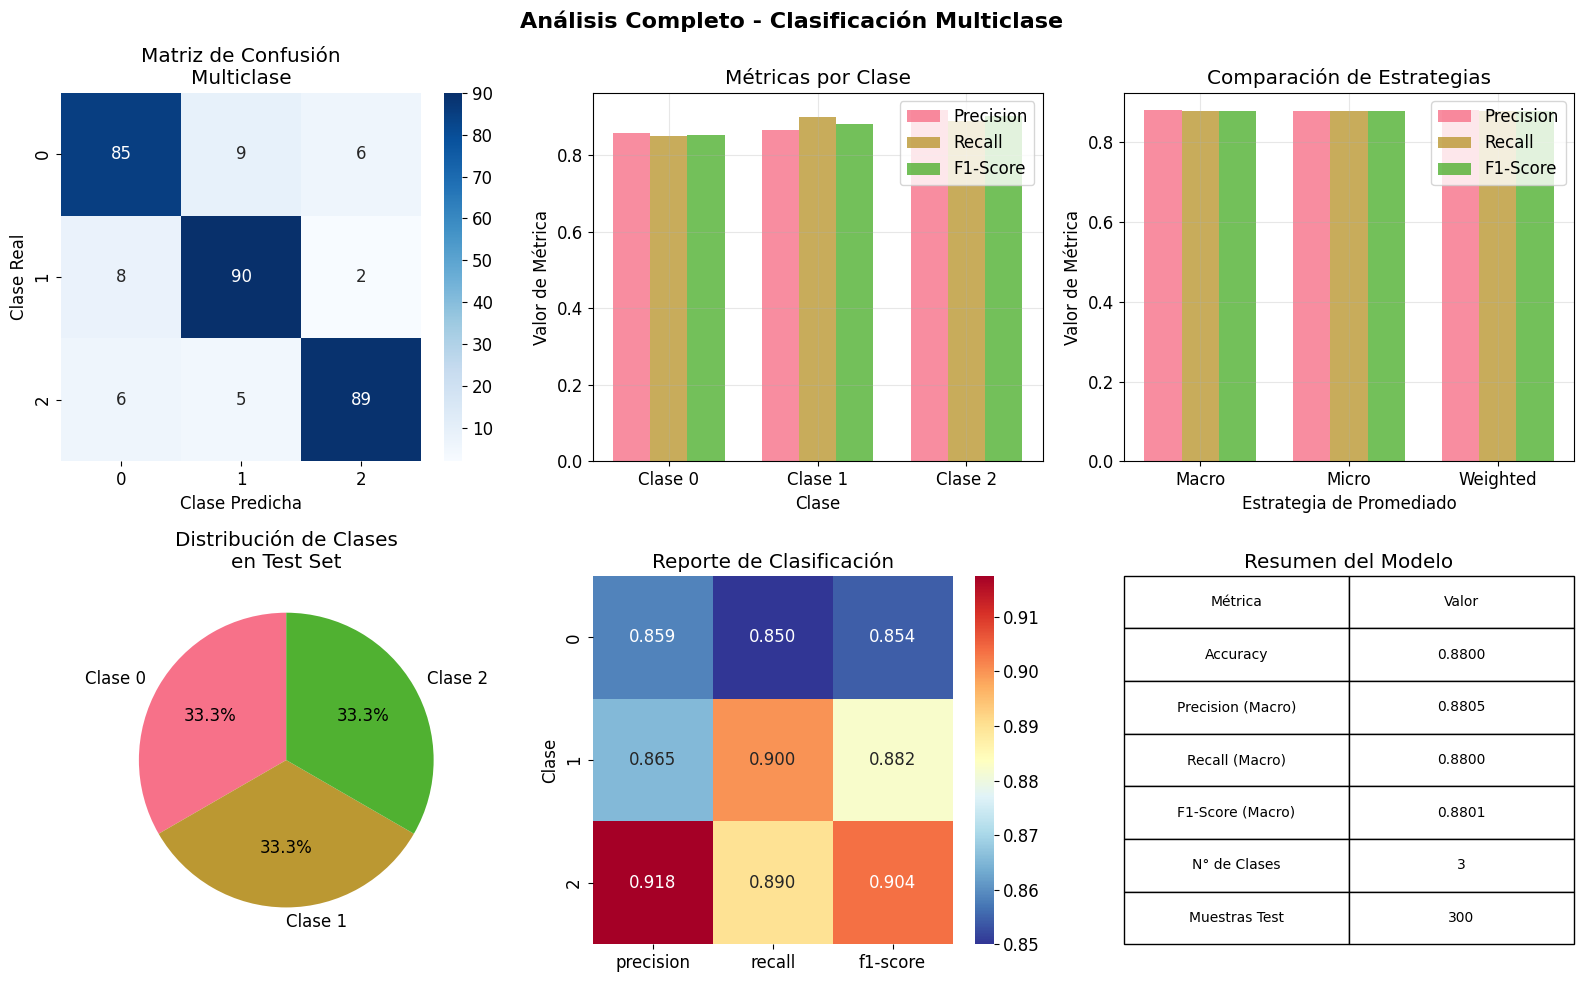

In [14]:
# Visualizar análisis multiclase
plt.figure(figsize=(16, 10))

# 1. Matriz de Confusión Multiclase
plt.subplot(2, 3, 1)
cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión\nMulticlase')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')

# 2. Métricas por Clase
plt.subplot(2, 3, 2)
classes = range(len(multiclass_metrics['precision_per_class']))
x = np.arange(len(classes))
width = 0.25

plt.bar(x - width, multiclass_metrics['precision_per_class'], width, label='Precision', alpha=0.8)
plt.bar(x, multiclass_metrics['recall_per_class'], width, label='Recall', alpha=0.8)
plt.bar(x + width, multiclass_metrics['f1_per_class'], width, label='F1-Score', alpha=0.8)

plt.xlabel('Clase')
plt.ylabel('Valor de Métrica')
plt.title('Métricas por Clase')
plt.xticks(x, [f'Clase {i}' for i in classes])
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Comparación de Estrategias de Promediado
plt.subplot(2, 3, 3)
strategies = ['Macro', 'Micro', 'Weighted']
precision_values = [multiclass_metrics['precision_macro'], 
                   multiclass_metrics['precision_micro'], 
                   multiclass_metrics['precision_weighted']]
recall_values = [multiclass_metrics['recall_macro'], 
                multiclass_metrics['recall_micro'], 
                multiclass_metrics['recall_weighted']]
f1_values = [multiclass_metrics['f1_macro'], 
            multiclass_metrics['f1_micro'], 
            multiclass_metrics['f1_weighted']]

x = np.arange(len(strategies))
plt.bar(x - width, precision_values, width, label='Precision', alpha=0.8)
plt.bar(x, recall_values, width, label='Recall', alpha=0.8)
plt.bar(x + width, f1_values, width, label='F1-Score', alpha=0.8)

plt.xlabel('Estrategia de Promediado')
plt.ylabel('Valor de Métrica')
plt.title('Comparación de Estrategias')
plt.xticks(x, strategies)
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Distribución de Clases
plt.subplot(2, 3, 4)
unique, counts = np.unique(y_test_multi, return_counts=True)
plt.pie(counts, labels=[f'Clase {i}' for i in unique], autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Clases\nen Test Set')

# 5. Reporte de Clasificación como Heatmap
plt.subplot(2, 3, 5)
report = classification_report(y_test_multi, y_pred_multi, output_dict=True)
# Convertir reporte a matriz para heatmap
metrics_names = ['precision', 'recall', 'f1-score']
class_names = [str(i) for i in range(len(unique))]
heatmap_data = []

for class_name in class_names:
    row = [report[class_name][metric] for metric in metrics_names]
    heatmap_data.append(row)

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlBu_r',
           xticklabels=metrics_names, yticklabels=class_names)
plt.title('Reporte de Clasificación')
plt.ylabel('Clase')

# 6. Tabla de Resumen
plt.subplot(2, 3, 6)
plt.axis('off')
summary_data = [
    ['Métrica', 'Valor'],
    ['Accuracy', f'{multiclass_metrics["accuracy"]:.4f}'],
    ['Precision (Macro)', f'{multiclass_metrics["precision_macro"]:.4f}'],
    ['Recall (Macro)', f'{multiclass_metrics["recall_macro"]:.4f}'],
    ['F1-Score (Macro)', f'{multiclass_metrics["f1_macro"]:.4f}'],
    ['N° de Clases', str(len(unique))],
    ['Muestras Test', str(len(y_test_multi))]
]

table = plt.table(cellText=summary_data[1:], colLabels=summary_data[0],
                 cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.title('Resumen del Modelo')

plt.suptitle('Análisis Completo - Clasificación Multiclase', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Guía de Selección de Métricas

Elegir la métrica correcta es crucial para evaluar adecuadamente el rendimiento del modelo. Aquí una guía práctica:

### 🎯 **Por Tipo de Problema:**

#### **Clasificación Binaria Balanceada:**
- **Accuracy**: Métrica principal
- **F1-Score**: Balance entre precision y recall
- **AUC-ROC**: Capacidad de discriminación

#### **Clasificación Binaria Desbalanceada:**
- **Precision**: Cuando los falsos positivos son costosos
- **Recall**: Cuando los falsos negativos son costosos  
- **AUC-PR**: Mejor que AUC-ROC para datasets desbalanceados
- **Balanced Accuracy**: Considera ambas clases igualmente

#### **Clasificación Multiclase:**
- **Accuracy**: Si las clases están balanceadas
- **Macro F1**: Tratamiento igual para todas las clases
- **Weighted F1**: Considera el desbalance de clases

#### **Regresión:**
- **MAE**: Interpretable y robusto a outliers
- **RMSE**: Penaliza errores grandes
- **R²**: Proporción de varianza explicada
- **MAPE**: Interpretación porcentual

### 📋 **Por Caso de Uso:**

#### **Detección de Fraude:**
- **Recall**: No queremos perder fraudes reales
- **Precision**: Evitar falsas alarmas
- **AUC-PR**: Dataset muy desbalanceado

#### **Diagnóstico Médico:**
- **Recall**: No perder casos positivos (sensibilidad)
- **Specificity**: Evitar falsos positivos
- **NPV**: Valor predictivo negativo

#### **Recomendaciones:**
- **Precision@K**: Precisión en top-K recomendaciones
- **Recall@K**: Cobertura en top-K
- **MAP**: Mean Average Precision

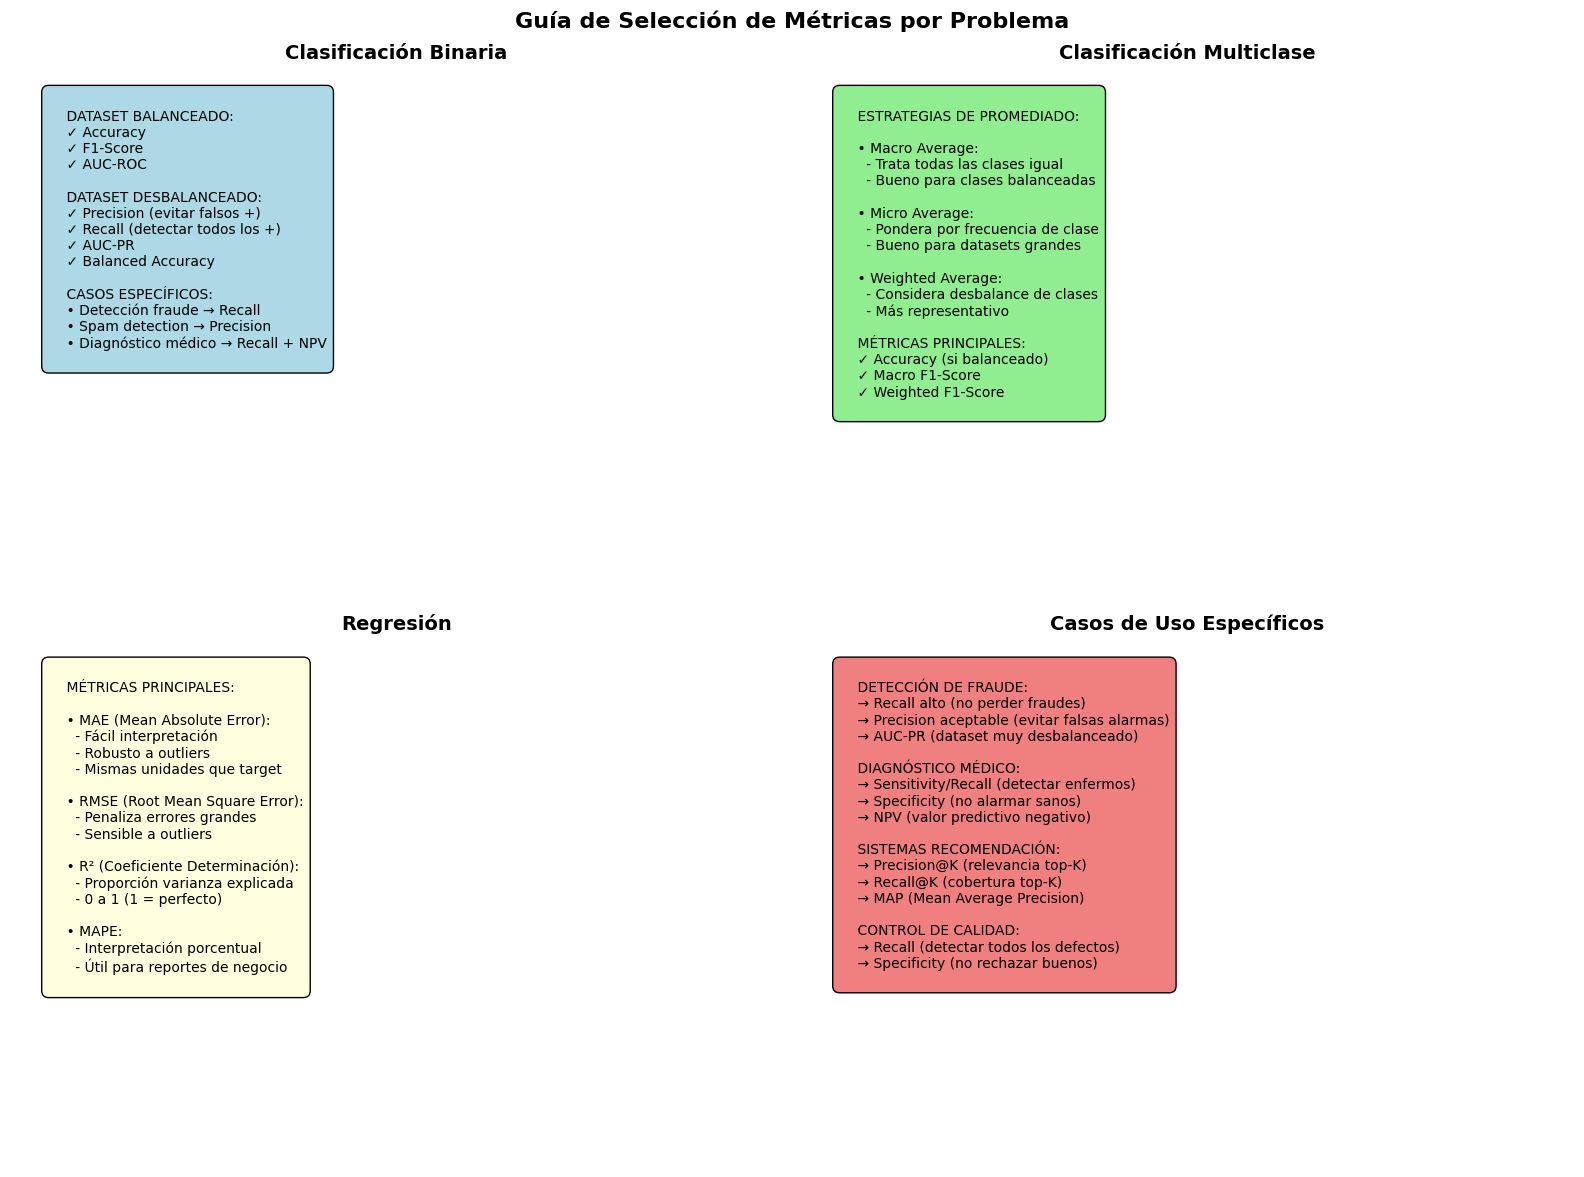

In [15]:
# Crear un resumen visual de selección de métricas
def create_metrics_selection_guide():
    """
    Crea una guía visual para selección de métricas
    """
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Clasificación Binaria
    ax1.set_title('Clasificación Binaria', fontweight='bold', fontsize=14)
    ax1.axis('off')
    
    binary_text = """
    DATASET BALANCEADO:
    ✓ Accuracy
    ✓ F1-Score  
    ✓ AUC-ROC
    
    DATASET DESBALANCEADO:
    ✓ Precision (evitar falsos +)
    ✓ Recall (detectar todos los +)
    ✓ AUC-PR
    ✓ Balanced Accuracy
    
    CASOS ESPECÍFICOS:
    • Detección fraude → Recall
    • Spam detection → Precision
    • Diagnóstico médico → Recall + NPV
    """
    
    ax1.text(0.05, 0.95, binary_text, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue'))
    
    # 2. Clasificación Multiclase
    ax2.set_title('Clasificación Multiclase', fontweight='bold', fontsize=14)
    ax2.axis('off')
    
    multi_text = """
    ESTRATEGIAS DE PROMEDIADO:
    
    • Macro Average:
      - Trata todas las clases igual
      - Bueno para clases balanceadas
    
    • Micro Average:
      - Pondera por frecuencia de clase
      - Bueno para datasets grandes
      
    • Weighted Average:
      - Considera desbalance de clases
      - Más representativo
      
    MÉTRICAS PRINCIPALES:
    ✓ Accuracy (si balanceado)
    ✓ Macro F1-Score
    ✓ Weighted F1-Score
    """
    
    ax2.text(0.05, 0.95, multi_text, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgreen'))
    
    # 3. Regresión
    ax3.set_title('Regresión', fontweight='bold', fontsize=14)
    ax3.axis('off')
    
    regression_text = """
    MÉTRICAS PRINCIPALES:
    
    • MAE (Mean Absolute Error):
      - Fácil interpretación
      - Robusto a outliers
      - Mismas unidades que target
    
    • RMSE (Root Mean Square Error):
      - Penaliza errores grandes
      - Sensible a outliers
      
    • R² (Coeficiente Determinación):
      - Proporción varianza explicada
      - 0 a 1 (1 = perfecto)
      
    • MAPE:
      - Interpretación porcentual
      - Útil para reportes de negocio
    """
    
    ax3.text(0.05, 0.95, regression_text, transform=ax3.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", facecolor='lightyellow'))
    
    # 4. Casos de Uso Específicos
    ax4.set_title('Casos de Uso Específicos', fontweight='bold', fontsize=14)
    ax4.axis('off')
    
    use_cases_text = """
    DETECCIÓN DE FRAUDE:
    → Recall alto (no perder fraudes)
    → Precision aceptable (evitar falsas alarmas)
    → AUC-PR (dataset muy desbalanceado)
    
    DIAGNÓSTICO MÉDICO:
    → Sensitivity/Recall (detectar enfermos)
    → Specificity (no alarmar sanos)
    → NPV (valor predictivo negativo)
    
    SISTEMAS RECOMENDACIÓN:
    → Precision@K (relevancia top-K)
    → Recall@K (cobertura top-K)
    → MAP (Mean Average Precision)
    
    CONTROL DE CALIDAD:
    → Recall (detectar todos los defectos)
    → Specificity (no rechazar buenos)
    """
    
    ax4.text(0.05, 0.95, use_cases_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", facecolor='lightcoral'))
    
    plt.suptitle('Guía de Selección de Métricas por Problema', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Mostrar guía de selección
create_metrics_selection_guide()

## 10. Resumen y Mejores Prácticas

### 📋 **Resumen de Métricas Implementadas:**

#### **Clasificación:**
- ✅ **Matriz de Confusión** - Base fundamental
- ✅ **Accuracy** - Proporción de predicciones correctas  
- ✅ **Precision** - De las predicciones positivas, cuántas correctas
- ✅ **Recall/Sensitivity** - De los casos positivos, cuántos detectados
- ✅ **Specificity** - De los casos negativos, cuántos detectados
- ✅ **F1-Score** - Media armónica precision-recall
- ✅ **AUC-ROC** - Área bajo curva ROC
- ✅ **AUC-PR** - Área bajo curva Precision-Recall
- ✅ **Balanced Accuracy** - Para datasets desbalanceados
- ✅ **Cohen's Kappa** - Acuerdo inter-evaluador
- ✅ **Matthews Correlation Coefficient** - Correlación entre predicción y realidad

#### **Regresión:**
- ✅ **MAE** - Error absoluto medio
- ✅ **RMSE** - Raíz del error cuadrático medio
- ✅ **R²** - Coeficiente de determinación
- ✅ **MAPE** - Error porcentual absoluto medio
- ✅ **Explained Variance** - Varianza explicada

### 🎯 **Mejores Prácticas:**

1. **Entiende tu problema de negocio** antes de elegir métricas
2. **Considera el desbalance de clases** en clasificación
3. **Usa múltiples métricas** para una evaluación completa
4. **Visualiza siempre la matriz de confusión**
5. **Analiza curvas ROC y PR** para entender el comportamiento del modelo
6. **Para regresión, analiza los residuos** para detectar patrones
7. **Reporta intervalos de confianza** cuando sea posible
8. **Considera el costo de diferentes tipos de errores**

### ⚠️ **Errores Comunes a Evitar:**

- ❌ Usar solo accuracy en datasets desbalanceados
- ❌ No considerar el contexto de negocio en la selección de métricas
- ❌ Ignorar la distribución de clases en el conjunto de prueba
- ❌ No validar las métricas con validación cruzada
- ❌ Comparar modelos usando métricas diferentes
- ❌ No reportar intervalos de confianza o desviación estándar